In [31]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

In [3]:
# Path ke folder dataset
dataset_dir = "./dataset"

In [33]:
# Inisialisasi ImageDataGenerator dengan augmentasi dan rescaling
train_datagen = ImageDataGenerator(
    rescale=1./255,        # Normalisasi gambar
    validation_split=0.2,  # Split dataset 80% train, 20% validation
    shear_range=0.2,       # Augmentasi: shear
    zoom_range=0.2,        # Augmentasi: zoom
    horizontal_flip=True   # Augmentasi: flip horizontal
)

# Muat dataset dari direktori
train_generator = train_datagen.flow_from_directory(
    dataset_dir,             # Path ke folder dataset
    target_size=(128, 128), # Ukuran gambar yang akan di-rescale
    batch_size=32,          # Batch size
    class_mode='categorical', # Mode klasifikasi
    subset='training',      # Subset untuk training
    shuffle=True            # Mengacak data
)

validation_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='validation',   # Subset untuk validasi
    shuffle=True
)

Found 1033 images belonging to 5 classes.
Found 256 images belonging to 5 classes.


In [34]:
# Load MobileNetV2 tanpa fully connected layers (include_top=False)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Tambahkan lapisan tambahan
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global Average Pooling
x = Dense(128, activation='relu')(x)  # Fully connected layer
predictions = Dense(train_generator.num_classes, activation='softmax')(x)  # Output layer

# Buat model akhir
model = Model(inputs=base_model.input, outputs=predictions)

# Bekukan layer di base_model agar tidak dilatih
for layer in base_model.layers:
    layer.trainable = False

# Kompilasi model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [35]:
# Melatih model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator
)

Epoch 1/10


c:\Users\Asus\anaconda3\envs\data_mlops_env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


33/33 ━━━━━━━━━━━━━━━━━━━━ 9s 175ms/step - accuracy: 0.5290 - loss: 1.2727 - val_accuracy: 0.7539 - val_loss: 0.6476
Epoch 2/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 178ms/step - accuracy: 0.8920 - loss: 0.3494 - val_accuracy: 0.8516 - val_loss: 0.4578
Epoch 3/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 0.9431 - loss: 0.2009 - val_accuracy: 0.8867 - val_loss: 0.3778
Epoch 4/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 0.9485 - loss: 0.1430 - val_accuracy: 0.9102 - val_loss: 0.2982
Epoch 5/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 0.9722 - loss: 0.1134 - val_accuracy: 0.8867 - val_loss: 0.3357
Epoch 6/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 0.9656 - loss: 0.1180 - val_accuracy: 0.8672 - val_loss: 0.3199
Epoch 7/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 0.9839 - loss: 0.0661 - val_accuracy: 0.8516 - val_loss: 0.3831
Epoch 8/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 0.9787 - loss: 0.0859 - val_accuracy: 0.8984 - val_

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Hasil prediksi: 7


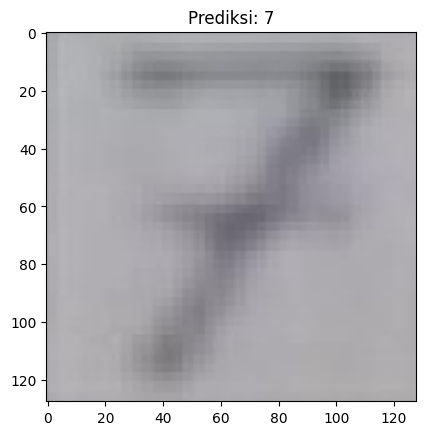

In [39]:
# Load dan preprocess salah satu gambar untuk pengujian
img_path = './dataset/7/image_92.jpg'  # Ubah ke path gambar yang diinginkan
img = image.load_img(img_path, target_size=(128, 128))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0  # Normalisasi gambar

# Prediksi gambar menggunakan model
predictions = model.predict(img_array)
predicted_class_idx = np.argmax(predictions, axis=1)[0]

# Dapatkan peta label dari train_generator
class_indices = train_generator.class_indices
# Membalik mapping: indeks ke label
labels = {v: k for k, v in class_indices.items()}

# Ambil label sebenarnya dari indeks prediksi
predicted_label = labels[predicted_class_idx]

# Tampilkan hasil prediksi
print(f"Hasil prediksi: {predicted_label}")

# Tampilkan gambar
plt.imshow(img)
plt.title(f"Prediksi: {predicted_label}")
plt.show()

In [ ]:
# Membuka kembali semua layer untuk fine-tuning
for layer in base_model.layers:
    layer.trainable = True

# Kompilasi ulang model dengan learning rate yang lebih kecil
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Melanjutkan pelatihan (fine-tuning)
model.fit(
    train_generator,
    epochs=5,
    validation_data=validation_generator
)